# Transfer learning
I will try to use transferlearning to build a model that can classify images of cats and dogs.

I will be following a tutorial from tensorflow found here:
https://www.tensorflow.org/tutorials/images/transfer_learning

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [6]:
# Downloading data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


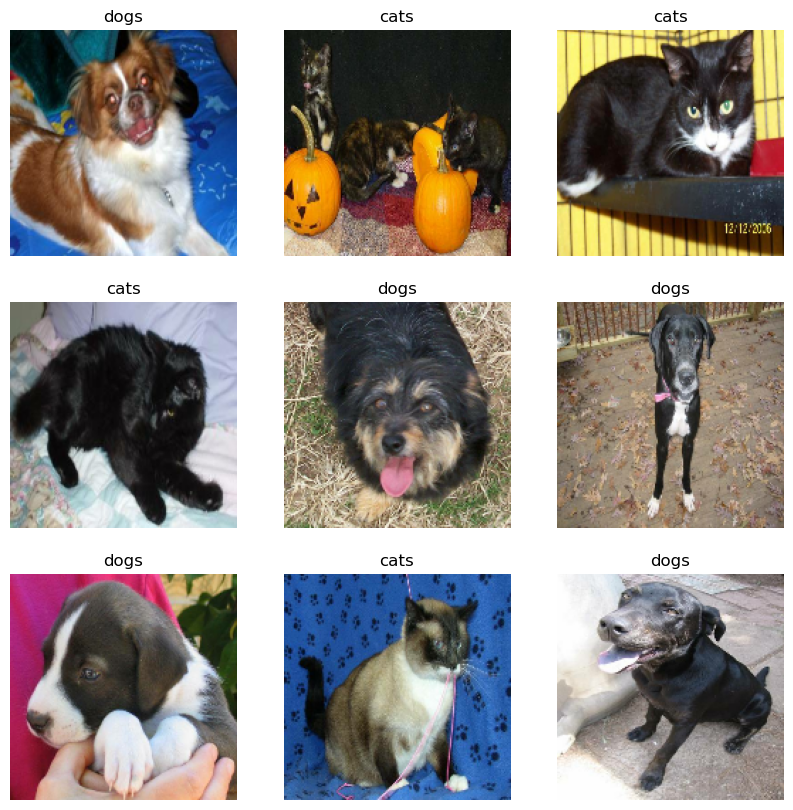

In [7]:
# Looking at some of the data
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [10]:
# Increase performance by introducing a internal buffer for the loaded data
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data augmentation
Since we dont have too much data, we will introduce some fake data by augmenting the ones we have.
This can be rotating and flipping the data.

In [11]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'),tf.keras.layers.RandomRotation(0.2),])

## Data mapping
The pretrained model(general one we will transfer) expects pixels betwee -1 and 1, but we currently have values from 0 to 255.

In [21]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [24]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Base model
We will use MobileNet V2 as our base model, which is developed by google. It is pretrained on 1.4M images, and 1k different classes, ranging from jackfruit to syringe.

We will disregard the top layer(if top is considered last), as this layer loses a lot of generality and we want the generality.


In [22]:
# Base model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
# Freeze the weights of the base model, since we dont want it to change
base_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [23]:
# looking at the model
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [26]:
# Introduce a classification head on top of the general model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [27]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [28]:
inputs = tf.keras.Input(shape=(160,160,3)) # Start by defining the shape of the input, here 160x160 and thre dimensions
x = data_augmentation(inputs) # Augment the data with the layer we defined earlier
x = preprocess_input(x) # Preprocess(rotate etc) as we defiend earlier
x = base_model(x, training = False) # Extract features by using the model discussed earlier as the base
x = global_average_layer(x) # 2D pooling
x = tf.keras.layers.Dropout(0.2)(x) # Dropout so that the model doesnt overfit
outputs = prediction_layer(x) # Add a prediction layer, as defined above. 
#Contains a single output, since we only have two classes
model = tf.keras.Model(inputs,outputs) # Put the model together

In [29]:
# Compile the model
base_learning_rate=0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

## Training the model
Now its time to train the model! We expect about ~90%

In [34]:
initial_epochs = 10
# Without training
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 9s 313ms/step - loss: 0.7907 - accuracy: 0.5099


In [35]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.79
initial accuracy: 0.51


As we can see, we get about 50% right, which is expected since the model isnt trained yet. next we will actually train the model. 

In [36]:
history = model.fit(train_dataset,epochs=initial_epochs,validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 37s 420ms/step - loss: 0.7095 - accuracy: 0.5750 - val_loss: 0.5407 - val_accuracy: 0.6522
Epoch 2/10
63/63 [==============================] - 22s 356ms/step - loss: 0.5154 - accuracy: 0.7060 - val_loss: 0.4062 - val_accuracy: 0.7661
Epoch 3/10
63/63 [==============================] - 23s 363ms/step - loss: 0.4273 - accuracy: 0.7730 - val_loss: 0.3152 - val_accuracy: 0.8465
Epoch 4/10
63/63 [==============================] - 22s 347ms/step - loss: 0.3479 - accuracy: 0.8365 - val_loss: 0.2529 - val_accuracy: 0.8923
Epoch 5/10
63/63 [==============================] - 22s 354ms/step - loss: 0.3146 - accuracy: 0.8540 - val_loss: 0.2195 - val_accuracy: 0.9158
Epoch 6/10
63/63 [==============================] - 22s 344ms/step - loss: 0.2816 - accuracy: 0.8705 - val_loss: 0.1916 - val_accuracy: 0.9332
Epoch 7/10
63/63 [==============================] - 22s 353ms/step - loss: 0.2515 - accuracy: 0.8855 - val_loss: 0.1745 - val_accuracy: 0.9332

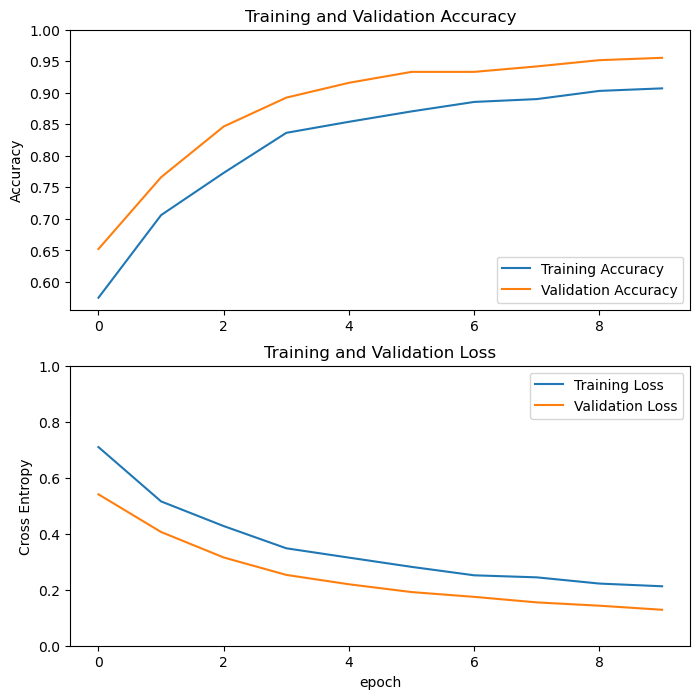

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
We will now unfreeze the top layers of the base model and fine tune them to improve our performance.

In [40]:
print("Number of layers in the base model: ", len(base_model.layers))
base_model.trainable=True

Number of layers in the base model:  154


There are 154 layers, so we will fine tune from 100 layers and up

In [41]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at:]:
    layer.trainable = False


In [42]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
metrics=['accuracy'])

In [43]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [45]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine=model.fit(train_dataset,epochs=total_epochs,initial_epoch=history.epoch[-1],
validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 47s 529ms/step - loss: 0.1494 - accuracy: 0.9405 - val_loss: 0.0572 - val_accuracy: 0.9802
Epoch 11/20
63/63 [==============================] - 36s 579ms/step - loss: 0.1245 - accuracy: 0.9530 - val_loss: 0.0455 - val_accuracy: 0.9851
Epoch 12/20
63/63 [==============================] - 30s 473ms/step - loss: 0.1141 - accuracy: 0.9535 - val_loss: 0.0431 - val_accuracy: 0.9802
Epoch 13/20
63/63 [==============================] - 33s 528ms/step - loss: 0.1021 - accuracy: 0.9560 - val_loss: 0.0411 - val_accuracy: 0.9777
Epoch 14/20
63/63 [==============================] - 30s 475ms/step - loss: 0.0876 - accuracy: 0.9650 - val_loss: 0.0401 - val_accuracy: 0.9802
Epoch 15/20
63/63 [==============================] - 30s 468ms/step - loss: 0.0833 - accuracy: 0.9710 - val_loss: 0.0357 - val_accuracy: 0.9889
Epoch 16/20
63/63 [==============================] - 28s 449ms/step - loss: 0.0776 - accuracy: 0.9705 - val_loss: 0.0442 - val_accuracy:

In [46]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

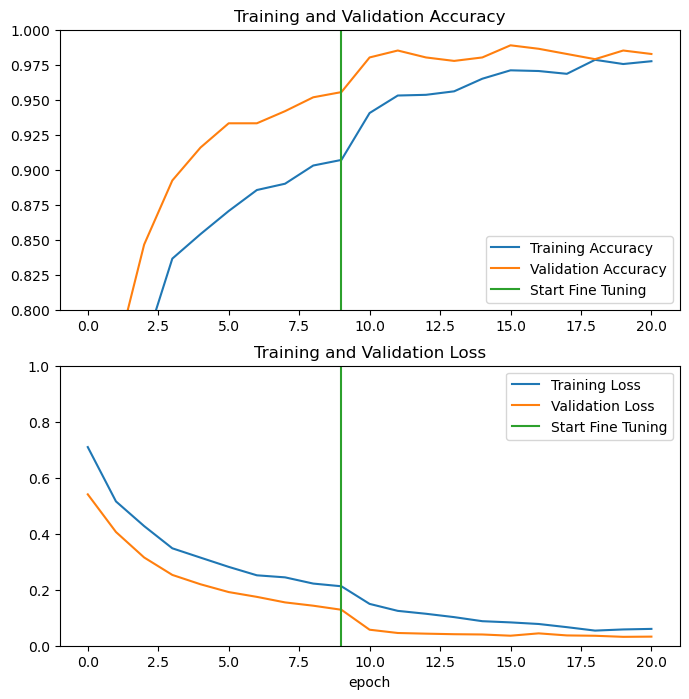

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Testing the model
We will now apply the model to the test-set and check its performance.


In [48]:
loss, accuracy = model.evaluate(test_dataset)
print('test accuracy:',accuracy)

6/6 [==============================] - 2s 349ms/step - loss: 0.0475 - accuracy: 0.9740
test accuracy: 0.9739583134651184


### Applying the model
Trying it to see some results

Predictions:
 [0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0]
Labels:
 [0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0]


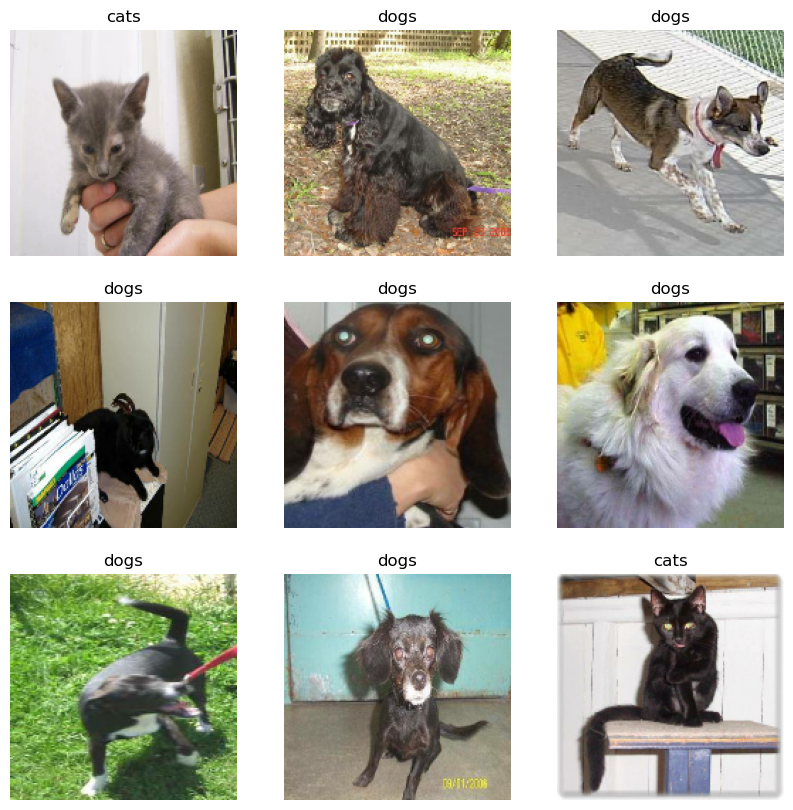

In [49]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [65]:
print(sum(predictions.numpy()))
print(sum(label_batch))


15
14
